In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
import matplotlib.pyplot as plt
import json
import cv2
import logging

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

LOG_FORMAT = "[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s"
logging.basicConfig(format=LOG_FORMAT)
logging.getLogger("IMG").setLevel(logging.DEBUG)
log = logging.getLogger("IMG")

class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

class ImageBatcher:
    def __init__(self, images, batch_size: int, image_size: int, shuffle: bool, drop_last: bool, max_batch: int = 0) -> None:
        log.info("Initializing image batcher")
        self.images = images
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.max_batch = max_batch

        self.num_images = self.images.shape[0]
        self.shape = (batch_size, self.images.shape[1], image_size, image_size)
        self.size = int(np.prod(self.shape))
        self.dtype = self.images.dtype
        self.nbytes = self.dtype.itemsize * self.size

        log.debug(f"Image Fields... \
            \n\tNumber of images: {self.num_images} \
            \n\tType: {self.dtype} \
            \n\tBatch Shape: {self.shape} \
            \n\tBatch Size: {self.size} \
            \n\tBatch Bytes: {self.nbytes}")

        self.indices = None
        self.current_index = 0
        self.current_batch = 0
        self.epoch = 0
        self._initialize_indices()

        log.info("Successfully created image batcher")

    def _initialize_indices(self) -> None:
        log.debug(f"Initializing indices. Shuffle: {self.shuffle}")
        self.indices = np.arange(self.num_images)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self) -> np.ndarray:
        self.current_batch += 1

        if self.current_index >= self.num_images:
            self._batch_completed()
            raise StopIteration
        
        if self.max_batch != 0 and self.current_batch > self.max_batch:
            self._batch_completed()
            raise StopIteration
        
        start_idx = self.current_index
        end_idx = min(self.current_index + self.batch_size, self.num_images)
        batch_indices = self.indices[start_idx: end_idx]

        if self.drop_last and end_idx - start_idx != self.batch_size:
            log.debug("Skipped last batch")
            self._batch_completed()
            raise StopIteration
        
        batch_images = self._get_batch_from_dataset(batch_indices)

        self.current_index = end_idx
        return batch_images

    def _batch_completed(self) -> None:
        log.info("Batch completed")
        self.epoch += 1
        self.current_index = 0
        self.current_batch = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_batch_from_dataset(self, indices: list[int]) -> np.ndarray:
        if self.shuffle:
            batch_images = []
            for i in indices:
                batch_images.append(self.images[i])
            
            batch_images = np.stack(batch_images, axis=0)
            return self._preprocess_images(batch_images)
        else:
            batch_images = self.images[indices]
            return self._preprocess_images(batch_images)

    def _preprocess_images(self, images: np.ndarray) -> np.ndarray:
        output_size = (self.image_size, self.image_size)
        resized_images = np.empty((images.shape[0], *output_size, 3))
        resized_images = resized_images.astype(self.dtype)

        for i, image in enumerate(images):
            if image.shape[2] == 4:  # If image has 4 channels (RGBA), convert to 3 channels (RGB)
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            resized_images[i] = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)
        
        return resized_images

# Function to resize images using the ImageBatcher
def resize_images_with_batcher(images, batch_size, image_size, shuffle=False):
    batcher = ImageBatcher(images, batch_size=batch_size, image_size=image_size, shuffle=shuffle, drop_last=False)
    resized_images = []

    for batch in batcher:
        resized_images.append(batch)

    return np.vstack(resized_images)

# Define directories
save_dir = './split_datav5_full_compressed'

# Load the split data
print("Loading data...")
train_data = np.load(os.path.join(save_dir, 'train_data.npz'))
val_data = np.load(os.path.join(save_dir, 'val_data.npz'))
test_data = np.load(os.path.join(save_dir, 'test_data.npz'))

X_rp_train = train_data['X_rp']
X_gaf_train = train_data['X_gaf']
X_mtf_train = train_data['X_mtf']
y_train = train_data['y']

X_rp_val = val_data['X_rp']
X_gaf_val = val_data['X_gaf']
X_mtf_val = val_data['X_mtf']
y_val = val_data['y']

X_rp_test = test_data['X_rp']
X_gaf_test = test_data['X_gaf']
X_mtf_test = test_data['X_mtf']
y_test = test_data['y']
print("Data loaded.")

print("Preprocessing images...")
X_rp_train = resize_images_with_batcher(X_rp_train, batch_size=32, image_size=224)
X_gaf_train = resize_images_with_batcher(X_gaf_train, batch_size=32, image_size=224)
X_mtf_train = resize_images_with_batcher(X_mtf_train, batch_size=32, image_size=224)
X_rp_val = resize_images_with_batcher(X_rp_val, batch_size=32, image_size=224)
X_gaf_val = resize_images_with_batcher(X_gaf_val, batch_size=32, image_size=224)
X_mtf_val = resize_images_with_batcher(X_mtf_val, batch_size=32, image_size=224)
X_rp_test = resize_images_with_batcher(X_rp_test, batch_size=32, image_size=224)
X_gaf_test = resize_images_with_batcher(X_gaf_test, batch_size=32, image_size=224)
X_mtf_test = resize_images_with_batcher(X_mtf_test, batch_size=32, image_size=224)
print("Images preprocessed.")

# Use a smaller batch size
batch_size = 4

# Generator to yield batches of data
def data_generator(X_rp, X_gaf, X_mtf, y, batch_size):
    num_samples = len(y)
    while True:
        for offset in range(0, num_samples, batch_size):
            X_rp_batch = X_rp[offset:offset+batch_size]
            X_gaf_batch = X_gaf[offset:offset+batch_size]
            X_mtf_batch = X_mtf[offset:offset+batch_size]
            y_batch = y[offset:offset+batch_size]
            yield ([X_rp_batch, X_gaf_batch, X_mtf_batch], y_batch)

train_gen = data_generator(X_rp_train, X_gaf_train, X_mtf_train, y_train, batch_size)
val_gen = data_generator(X_rp_val, X_gaf_val, X_mtf_val, y_val, batch_size)
test_gen = data_generator(X_rp_test, X_gaf_test, X_mtf_test, y_test, batch_size)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Clear any existing TensorFlow sessions
tf.keras.backend.clear_session()

# Train VGG16 model
print("Starting training...")
steps_per_epoch = len(y_train) // batch_size
validation_steps = len(y_val) // batch_size
vgg16_history = vgg16_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger()],
    verbose=1
)

# Evaluate VGG16 model on the test set
print("Evaluating on test set...")
test_steps = len(y_test) // batch_size
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_gen, steps=test_steps)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")

2024-07-08 01:30:28.911971: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-08 01:30:28.941836: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 01:30:28.941864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 01:30:28.942534: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-08 01:30:28.947416: I tensorflow/core/platform/cpu_feature_guar

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPUs will likely run quickly with dtype policy mixed_float16 as they all have compute capability of at least 7.0
Loading data...


[2024-07-08 01:32:13,261] [IMG] [INFO] Initializing image batcher
[2024-07-08 01:32:13,269] [IMG] [DEBUG] Image Fields...             
	Number of images: 70480             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-08 01:32:13,270] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-08 01:32:13,271] [IMG] [INFO] Successfully created image batcher


Data loaded.
Preprocessing images...


[2024-07-08 01:32:27,909] [IMG] [INFO] Batch completed
[2024-07-08 01:32:31,007] [IMG] [INFO] Initializing image batcher
[2024-07-08 01:32:31,008] [IMG] [DEBUG] Image Fields...             
	Number of images: 70480             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-08 01:32:31,013] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-08 01:32:31,014] [IMG] [INFO] Successfully created image batcher
/tmp/ipykernel_141631/1274757522.py:119: RuntimeWarning: invalid value encountered in cast
  resized_images = resized_images.astype(self.dtype)
[2024-07-08 01:32:48,846] [IMG] [INFO] Batch completed
[2024-07-08 01:32:52,229] [IMG] [INFO] Initializing image batcher
[2024-07-08 01:32:52,230] [IMG] [DEBUG] Image Fields...             
	Number of images: 70480             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch 

Images preprocessed.


2024-07-08 01:33:36.803832: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8231 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:1a:00.0, compute capability: 8.6
2024-07-08 01:33:36.806007: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 8100 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:68:00.0, compute capability: 8.6


Starting training...

Epoch 1 started.
Epoch 1/10


2024-07-08 01:33:44.801133: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902


    4/17620 [..............................] - ETA: 14:41 - loss: 36.2656 - accuracy: 0.0000e+00 

2024-07-08 01:33:48.432948: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2d00003700 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-07-08 01:33:48.433015: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-08 01:33:48.433028: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3080, Compute Capability 8.6
2024-07-08 01:33:48.509582: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1720427628.713854  161491 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


13034/17620 [=====================>........] - ETA: 3:31 - loss: nan - accuracy: 0.0281

KeyboardInterrupt: 

Loading data...


[2024-07-08 01:47:30,648] [IMG] [INFO] Initializing image batcher
[2024-07-08 01:47:30,649] [IMG] [DEBUG] Image Fields...             
	Number of images: 70480             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-08 01:47:30,649] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-08 01:47:30,650] [IMG] [INFO] Successfully created image batcher


Data loaded.
Preprocessing images...


[2024-07-08 01:47:48,863] [IMG] [INFO] Batch completed
[2024-07-08 01:47:55,246] [IMG] [INFO] Initializing image batcher
[2024-07-08 01:47:55,247] [IMG] [DEBUG] Image Fields...             
	Number of images: 70480             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-08 01:47:55,248] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-08 01:47:55,249] [IMG] [INFO] Successfully created image batcher
[2024-07-08 01:48:12,616] [IMG] [INFO] Batch completed
[2024-07-08 01:48:15,645] [IMG] [INFO] Initializing image batcher
[2024-07-08 01:48:15,646] [IMG] [DEBUG] Image Fields...             
	Number of images: 70480             
	Type: uint8             
	Batch Shape: (32, 201, 224, 224)             
	Batch Size: 322732032             
	Batch Bytes: 322732032
[2024-07-08 01:48:15,647] [IMG] [DEBUG] Initializing indices. Shuffle: False
[2024-07-08 01:48:15,649] [IMG] [INFO] Successfull

Images preprocessed.
Starting training...

Epoch 1 started.
Epoch 1/10
17620/17620 [==============================] - ETA: 0s - loss: 0.4783 - accuracy: 0.8961
Epoch 1 ended.
Accuracy: 0.8961 - Loss: 0.4783 - Val Accuracy: 0.9005 - Val Loss: 0.3809
17620/17620 [==============================] - 1085s 61ms/step - loss: 0.4783 - accuracy: 0.8961 - val_loss: 0.3809 - val_accuracy: 0.9005 - lr: 1.0000e-04

Epoch 2 started.
Epoch 2/10
17620/17620 [==============================] - ETA: 0s - loss: 0.5701 - accuracy: 0.9013
Epoch 2 ended.
Accuracy: 0.9013 - Loss: 0.5701 - Val Accuracy: 0.9025 - Val Loss: 0.3477
17620/17620 [==============================] - 1065s 60ms/step - loss: 0.5701 - accuracy: 0.9013 - val_loss: 0.3477 - val_accuracy: 0.9025 - lr: 1.0000e-04

Epoch 3 started.
Epoch 3/10
17620/17620 [==============================] - ETA: 0s - loss: nan - accuracy: 0.9017
Epoch 3 ended.
Accuracy: 0.9017 - Loss: nan - Val Accuracy: 0.9026 - Val Loss: 0.3455
17620/17620 [==================

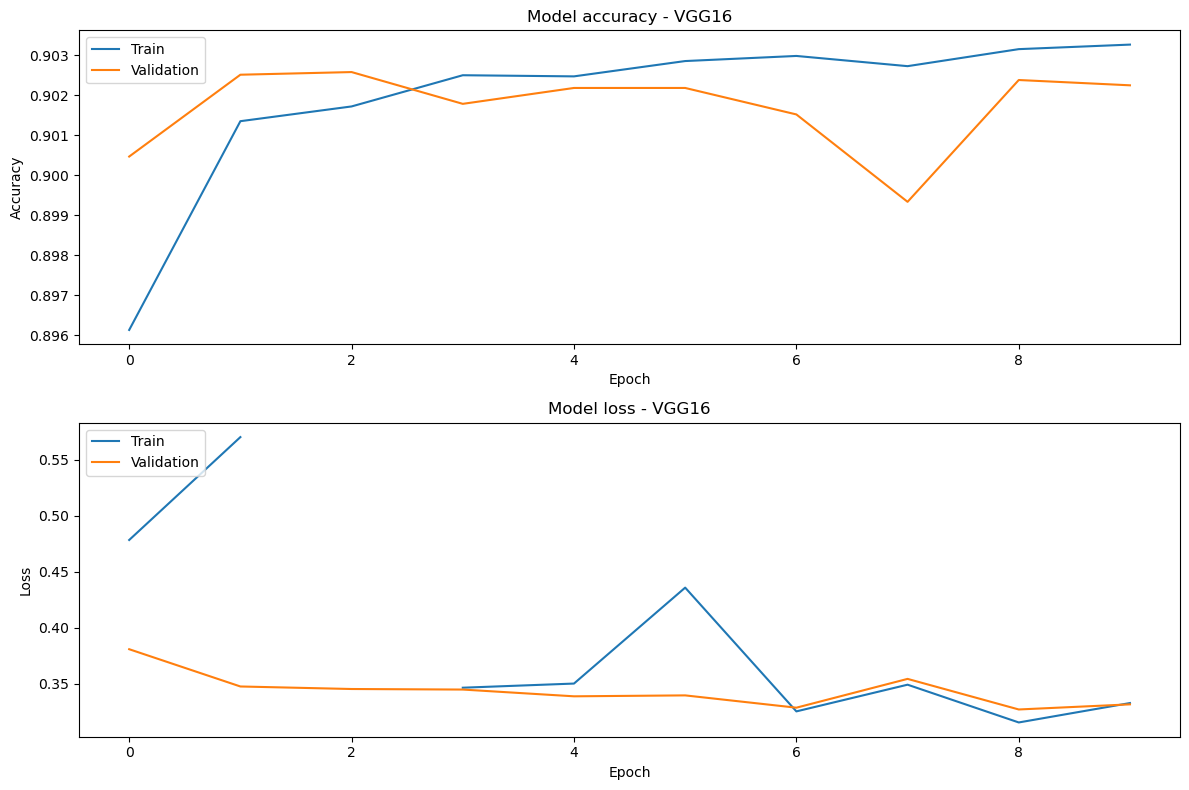

TypeError: Object of type float32 is not JSON serializable

In [2]:
#Some adjustments
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.layers import Input, Dense, Flatten, Concatenate, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback, LearningRateScheduler
import matplotlib.pyplot as plt
import json
import cv2
import logging

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

LOG_FORMAT = "[%(asctime)s] [%(name)s] [%(levelname)s] %(message)s"
logging.basicConfig(format=LOG_FORMAT)
logging.getLogger("IMG").setLevel(logging.DEBUG)
log = logging.getLogger("IMG")

class PrintLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} started.")
    
    def on_epoch_end(self, epoch, logs=None):
        print(f"\nEpoch {epoch + 1} ended.")
        print(f"Accuracy: {logs['accuracy']:.4f} - Loss: {logs['loss']:.4f} - Val Accuracy: {logs['val_accuracy']:.4f} - Val Loss: {logs['val_loss']:.4f}")

class ImageBatcher:
    def __init__(self, images, batch_size: int, image_size: int, shuffle: bool, drop_last: bool, max_batch: int = 0) -> None:
        log.info("Initializing image batcher")
        self.images = images
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.max_batch = max_batch

        self.num_images = self.images.shape[0]
        self.shape = (batch_size, self.images.shape[1], image_size, image_size)
        self.size = int(np.prod(self.shape))
        self.dtype = self.images.dtype
        self.nbytes = self.dtype.itemsize * self.size

        log.debug(f"Image Fields... \
            \n\tNumber of images: {self.num_images} \
            \n\tType: {self.dtype} \
            \n\tBatch Shape: {self.shape} \
            \n\tBatch Size: {self.size} \
            \n\tBatch Bytes: {self.nbytes}")

        self.indices = None
        self.current_index = 0
        self.current_batch = 0
        self.epoch = 0
        self._initialize_indices()

        log.info("Successfully created image batcher")

    def _initialize_indices(self) -> None:
        log.debug(f"Initializing indices. Shuffle: {self.shuffle}")
        self.indices = np.arange(self.num_images)

        if self.shuffle:
            np.random.shuffle(self.indices)

    def __iter__(self):
        return self

    def __next__(self) -> np.ndarray:
        self.current_batch += 1

        if self.current_index >= self.num_images:
            self._batch_completed()
            raise StopIteration
        
        if self.max_batch != 0 and self.current_batch > self.max_batch:
            self._batch_completed()
            raise StopIteration
        
        start_idx = self.current_index
        end_idx = min(self.current_index + self.batch_size, self.num_images)
        batch_indices = self.indices[start_idx: end_idx]

        if self.drop_last and end_idx - start_idx != self.batch_size:
            log.debug("Skipped last batch")
            self._batch_completed()
            raise StopIteration
        
        batch_images = self._get_batch_from_dataset(batch_indices)

        self.current_index = end_idx
        return batch_images

    def _batch_completed(self) -> None:
        log.info("Batch completed")
        self.epoch += 1
        self.current_index = 0
        self.current_batch = 0

        if self.shuffle:
            np.random.shuffle(self.indices)

    def _get_batch_from_dataset(self, indices: list[int]) -> np.ndarray:
        if self.shuffle:
            batch_images = []
            for i in indices:
                batch_images.append(self.images[i])
            
            batch_images = np.stack(batch_images, axis=0)
            return self._preprocess_images(batch_images)
        else:
            batch_images = self.images[indices]
            return self._preprocess_images(batch_images)

    def _preprocess_images(self, images: np.ndarray) -> np.ndarray:
        output_size = (self.image_size, self.image_size)
        resized_images = np.empty((images.shape[0], *output_size, 3))
        resized_images = resized_images.astype(self.dtype)

        for i, image in enumerate(images):
            if image.shape[2] == 4:  # If image has 4 channels (RGBA), convert to 3 channels (RGB)
                image = cv2.cvtColor(image, cv2.COLOR_RGBA2RGB)
            resized_images[i] = cv2.resize(image, output_size, interpolation=cv2.INTER_LINEAR)
        
        return resized_images

# Function to resize images using the ImageBatcher
def resize_images_with_batcher(images, batch_size, image_size, shuffle=False):
    batcher = ImageBatcher(images, batch_size=batch_size, image_size=image_size, shuffle=shuffle, drop_last=False)
    resized_images = []

    for batch in batcher:
        resized_images.append(batch)

    return np.vstack(resized_images)

# Define directories
save_dir = './split_datav5_full_compressed'

# Load the split data
print("Loading data...")
train_data = np.load(os.path.join(save_dir, 'train_data.npz'))
val_data = np.load(os.path.join(save_dir, 'val_data.npz'))
test_data = np.load(os.path.join(save_dir, 'test_data.npz'))

X_rp_train = train_data['X_rp']
X_gaf_train = train_data['X_gaf']
X_mtf_train = train_data['X_mtf']
y_train = train_data['y']

X_rp_val = val_data['X_rp']
X_gaf_val = val_data['X_gaf']
X_mtf_val = val_data['X_mtf']
y_val = val_data['y']

X_rp_test = test_data['X_rp']
X_gaf_test = test_data['X_gaf']
X_mtf_test = test_data['X_mtf']
y_test = test_data['y']
print("Data loaded.")

print("Preprocessing images...")
X_rp_train = resize_images_with_batcher(X_rp_train, batch_size=32, image_size=224)
X_gaf_train = resize_images_with_batcher(X_gaf_train, batch_size=32, image_size=224)
X_mtf_train = resize_images_with_batcher(X_mtf_train, batch_size=32, image_size=224)
X_rp_val = resize_images_with_batcher(X_rp_val, batch_size=32, image_size=224)
X_gaf_val = resize_images_with_batcher(X_gaf_val, batch_size=32, image_size=224)
X_mtf_val = resize_images_with_batcher(X_mtf_val, batch_size=32, image_size=224)
X_rp_test = resize_images_with_batcher(X_rp_test, batch_size=32, image_size=224)
X_gaf_test = resize_images_with_batcher(X_gaf_test, batch_size=32, image_size=224)
X_mtf_test = resize_images_with_batcher(X_mtf_test, batch_size=32, image_size=224)
print("Images preprocessed.")

# Use a smaller batch size
batch_size = 4

# Generator to yield batches of data
def data_generator(X_rp, X_gaf, X_mtf, y, batch_size):
    num_samples = len(y)
    while True:
        for offset in range(0, num_samples, batch_size):
            X_rp_batch = X_rp[offset:offset+batch_size]
            X_gaf_batch = X_gaf[offset:offset+batch_size]
            X_mtf_batch = X_mtf[offset:offset+batch_size]
            y_batch = y[offset:offset+batch_size]
            yield ([X_rp_batch, X_gaf_batch, X_mtf_batch], y_batch)

train_gen = data_generator(X_rp_train, X_gaf_train, X_mtf_train, y_train, batch_size)
val_gen = data_generator(X_rp_val, X_gaf_val, X_mtf_val, y_val, batch_size)
test_gen = data_generator(X_rp_test, X_gaf_test, X_mtf_test, y_test, batch_size)

# Define a function to build the VGG16 model
def build_vgg16_model(input_shape, num_classes):
    inputs_rp = Input(shape=input_shape, name='input_rp')
    inputs_gaf = Input(shape=input_shape, name='input_gaf')
    inputs_mtf = Input(shape=input_shape, name='input_mtf')

    base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_shape)

    base_rp = clone_model(base_model)
    base_rp._name = 'base_rp'
    base_rp.set_weights(base_model.get_weights())
    x_rp = base_rp(inputs_rp)
    x_rp = Flatten(name='flatten_rp')(x_rp)

    base_gaf = clone_model(base_model)
    base_gaf._name = 'base_gaf'
    base_gaf.set_weights(base_model.get_weights())
    x_gaf = base_gaf(inputs_gaf)
    x_gaf = Flatten(name='flatten_gaf')(x_gaf)

    base_mtf = clone_model(base_model)
    base_mtf._name = 'base_mtf'
    base_mtf.set_weights(base_model.get_weights())
    x_mtf = base_mtf(inputs_mtf)
    x_mtf = Flatten(name='flatten_mtf')(x_mtf)

    merged = Concatenate(name='concat')([x_rp, x_gaf, x_mtf])

    x = Dense(512, activation='relu', name='dense_512')(merged)
    x = Dropout(0.5, name='dropout_512')(x)
    x = Dense(128, activation='relu', name='dense_128')(x)
    x = Dropout(0.5, name='dropout_128')(x)
    outputs = Dense(num_classes, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs_rp, inputs_gaf, inputs_mtf], outputs=outputs)
    return model

# Define input shape and number of classes
input_shape = (224, 224, 3)
num_classes = 5

# Build VGG16 model
vgg16_model = build_vgg16_model(input_shape, num_classes)
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                    loss='sparse_categorical_crossentropy', 
                    metrics=['accuracy'])

# Define early stopping and model checkpoint callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
vgg16_checkpoint = ModelCheckpoint(filepath=os.path.join(save_dir, 'vgg16_best_model.keras'), monitor='val_loss', save_best_only=True)

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 5:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

lr_scheduler = LearningRateScheduler(scheduler)

# Clear any existing TensorFlow sessions
tf.keras.backend.clear_session()

# Train VGG16 model
print("Starting training...")
steps_per_epoch = len(y_train) // batch_size
validation_steps = len(y_val) // batch_size
vgg16_history = vgg16_model.fit(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=10,
    validation_data=val_gen,
    validation_steps=validation_steps,
    callbacks=[early_stopping, vgg16_checkpoint, PrintLogger(), lr_scheduler],
    verbose=1
)

# Evaluate VGG16 model on the test set
print("Evaluating on test set...")
test_steps = len(y_test) // batch_size
vgg16_model.load_weights(os.path.join(save_dir, 'vgg16_best_model.keras'))
vgg16_test_loss, vgg16_test_accuracy = vgg16_model.evaluate(test_gen, steps=test_steps)
print(f'VGG16 Test loss: {vgg16_test_loss:.4f}')
print(f'VGG16 Test accuracy: {vgg16_test_accuracy:.4f}')

# Function to plot learning curves
def plot_learning_curve(history, model_name):
    plt.figure(figsize=(12, 8))

    # Plot training & validation accuracy values
    plt.subplot(2, 1, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy - {model_name}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(2, 1, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss - {model_name}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Plot learning curve for VGG16
plot_learning_curve(vgg16_history, 'VGG16')

# Save the final VGG16 model
vgg16_model.save(os.path.join(save_dir, 'vgg16_model.keras'))

# Save the training history
with open(os.path.join(save_dir, 'vgg16_history.json'), 'w') as f:
    json.dump(vgg16_history.history, f)

print(f"VGG16 model and history saved in directory: {save_dir}")
